In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Workout actual mean and std of WHOLE dataset
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_dataset = Flowers102(root='', split='train', transform=transform, download=True)
test_dataset = Flowers102(root='', split='test', transform=transform, download=True)
val_dataset = Flowers102(root='', split='val', transform=transform, download=True)
dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset, val_dataset])
print(len(dataset))

# R, G, B
channel_sum = torch.zeros(3)
channel_sum_squared = torch.zeros(3)
count = 0

for img, _ in dataset:
    channel_sum += torch.mean(img, dim=(1, 2))
    channel_sum_squared += torch.mean(img ** 2, dim=(1, 2))
    count += 1

mean = channel_sum / count
std = torch.sqrt(channel_sum_squared / count - mean ** 2)

print("Mean:", mean)
print("Std:", std)

8189
Mean: tensor([0.4355, 0.3777, 0.2879])
Std: tensor([0.2968, 0.2459, 0.2703])


In [3]:
train_transform = v2.Compose([
		 v2.ToImage(),
		 v2.Resize((224, 224)),
		 v2.RandomHorizontalFlip(),
		 v2.RandomPerspective(p=0.3), # looking at the images a lot of flowers are at diff perspectives
		 v2.ToDtype(torch.float32, scale=True),
		 v2.Normalize(mean=mean.numpy(), std=std.numpy()),
])

transform = v2.Compose([
		 v2.ToImage(),
		 v2.Resize((224, 224)),
		 v2.ToDtype(torch.float32, scale=True),
		 v2.Normalize(mean=mean.numpy(), std=std.numpy()),

])

In [4]:
training_data = Flowers102( root='', split='train', transform=train_transform, download=False)
testing_data = Flowers102(root='',split='test',transform=transform,download=False)
evaluation_data = Flowers102(root='',split='val',transform=transform,download=False)

In [5]:
print('Training data has {} instances'.format(len(training_data)))
print('Evaluation data has {} instances'.format(len(evaluation_data)))
print('Testing data has {} instances'.format(len(testing_data)))

Training data has 1020 instances
Evaluation data has 1020 instances
Testing data has 6149 instances


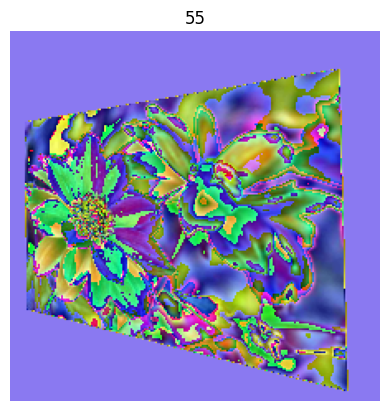

In [6]:
img, label = training_data[555] # just a random instance to see how the data has been normalised
np_img = img.permute(1, 2, 0).numpy()
plt.title(label)
plt.imshow((np_img * 255).astype('uint8'))
plt.axis('off')
plt.show()

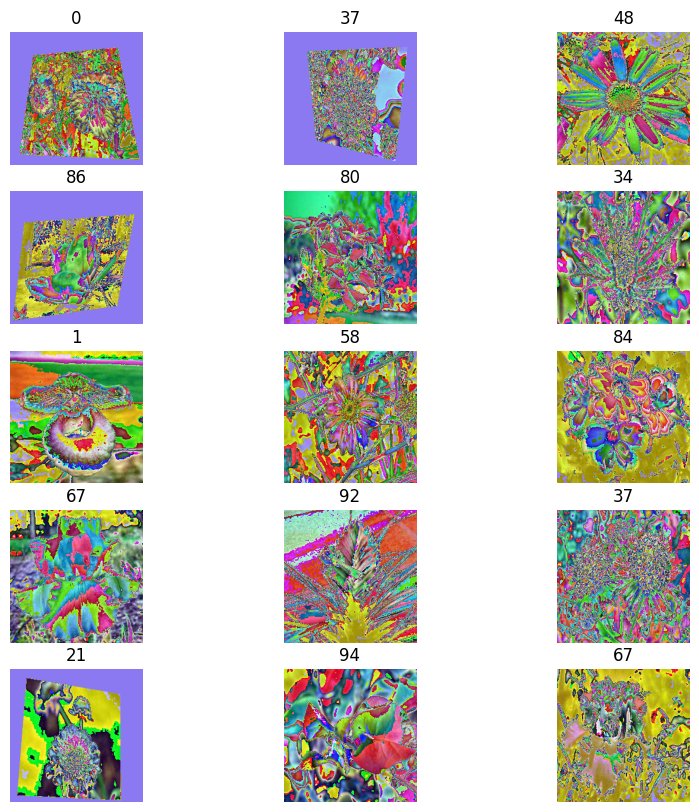

In [7]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
	sample_idx = torch.randint(len(training_data), size=(1,)).item()
	img, label = training_data[sample_idx]

	np_img = img.permute(1, 2, 0).numpy()
	figure.add_subplot(rows, cols, i)
	plt.title(label)
	plt.imshow((np_img * 255).astype('uint8'))
	plt.axis('off')
plt.show()

In [8]:
# transform simple NN into a CNN
class FlowerClassifier(nn.Module):
	def __init__(self):
			super(FlowerClassifier, self).__init__()
			self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
			self.bn1 = nn.BatchNorm2d(64)
			self.relu = nn.ReLU()
			self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
			self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
			self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

			self.flatten = nn.Flatten()
			self.fc1 = nn.Linear(256 * 28 * 28, 102)

	def forward(self, x):
			x = self.pool(self.relu(self.bn1(self.conv1(x))))
			x = self.pool(self.relu(self.conv2(x)))
			x = self.pool(self.relu(self.conv3(x)))
			x = self.flatten(x)
			x = self.fc1(x)
			return F.log_softmax(x, dim=1)

In [9]:
training_loader = DataLoader(training_data, batch_size=128, shuffle=True)
evaluation_loader = DataLoader(evaluation_data, batch_size=128, shuffle=False)

In [10]:
# Check if CUDA is available
if torch.cuda.is_available():
	print("CUDA is available!")
	device = torch.device("cuda")
else:
	print("CUDA is not available. The model will use CPU.")
	device = torch.device("cpu")

CUDA is available!


In [11]:
def train(model, training_loader, evaluation_loader, criterion, optimizer, patience=5, epochs=10):
	train_losses = []
	eval_losses = []
	eval_accuracies = []

	best_valid_loss = np.inf
	patience_counter = 0

	for epoch in range(epochs):
		model.train()
		training_loss = 0.0
		for inputs, labels in training_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			optimizer.zero_grad()
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			training_loss += loss.item() * inputs.size(0)

		training_loss /= len(training_loader.dataset)
		train_losses.append(training_loss)

		model.eval()
		evaluation_loss = 0.0
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in evaluation_loader:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				loss = criterion(outputs, labels)
				evaluation_loss += loss.item() * inputs.size(0)
				_, predicted = torch.max(outputs, 1)
				total += labels.size(0)
				correct += (predicted == labels).sum().item()

		evaluation_loss /= len(evaluation_loader.dataset)
		evaluation_accuracy = correct / total
		eval_losses.append(evaluation_loss)
		eval_accuracies.append(evaluation_accuracy)

		print(
			f'Epoch {epoch + 1}/{epochs}, Training Loss: {training_loss:.4f}, Evaluation Loss: {evaluation_loss:.4f}, Val Accuracy: {evaluation_accuracy:.4f}')

		if evaluation_loss < best_valid_loss:
				best_valid_loss = evaluation_loss
				patience_counter = 0
		else:
				patience_counter += 1
				if patience_counter >= patience:
						print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
						break

	print('Training finished.')

	# Plotting the training and evaluation losses
	plt.figure(figsize=(8, 4))
	plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
	plt.plot(range(1, len(eval_losses) + 1), eval_losses, label='Evaluation Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Training and Evaluation Losses')
	plt.legend()
	plt.show()

	# Plotting the evaluation accuracy
	plt.figure(figsize=(8, 4))
	plt.plot(range(1, len(eval_accuracies) + 1), eval_accuracies, label='Validation Accuracy')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.title('Validation Accuracy')
	plt.legend()
	plt.show()

Epoch 1/100, Training Loss: 4.9381, Evaluation Loss: 4.4600, Val Accuracy: 0.0676
Epoch 2/100, Training Loss: 4.1310, Evaluation Loss: 4.0128, Val Accuracy: 0.1059
Epoch 3/100, Training Loss: 3.3552, Evaluation Loss: 3.4653, Val Accuracy: 0.2157
Epoch 4/100, Training Loss: 2.7522, Evaluation Loss: 3.4231, Val Accuracy: 0.2098
Epoch 5/100, Training Loss: 2.3280, Evaluation Loss: 3.2577, Val Accuracy: 0.2549
Epoch 6/100, Training Loss: 1.9074, Evaluation Loss: 3.1675, Val Accuracy: 0.2784
Epoch 7/100, Training Loss: 1.6330, Evaluation Loss: 3.2044, Val Accuracy: 0.3000
Epoch 8/100, Training Loss: 1.3291, Evaluation Loss: 3.2280, Val Accuracy: 0.3069
Epoch 9/100, Training Loss: 1.1390, Evaluation Loss: 3.3889, Val Accuracy: 0.3088
Epoch 10/100, Training Loss: 1.0033, Evaluation Loss: 3.2843, Val Accuracy: 0.3265
Epoch 11/100, Training Loss: 0.8399, Evaluation Loss: 3.4789, Val Accuracy: 0.3118
Validation loss did not improve for 5 epochs. Early stopping...
Training finished.


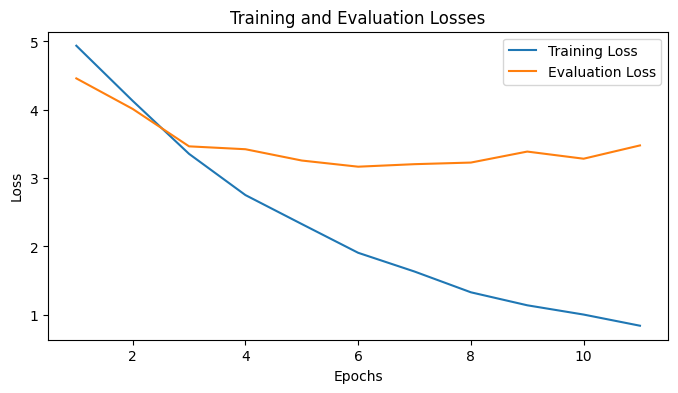

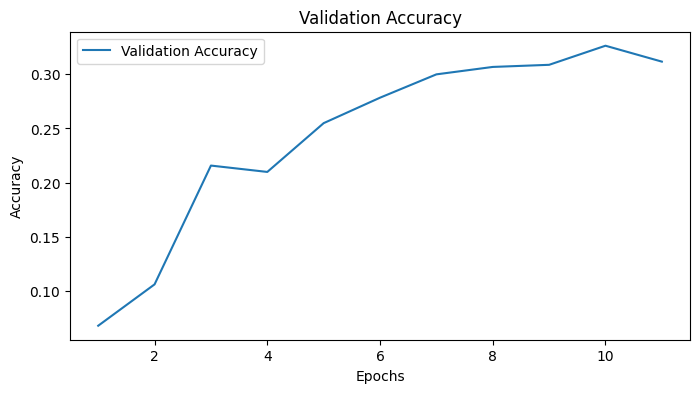

In [12]:
model = FlowerClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train(model, training_loader, evaluation_loader, criterion, optimizer, epochs=100)

Evaluation Loss: 3.4789, Accuracy: 0.3118
There were 702 images predicted incorrectly by the model.


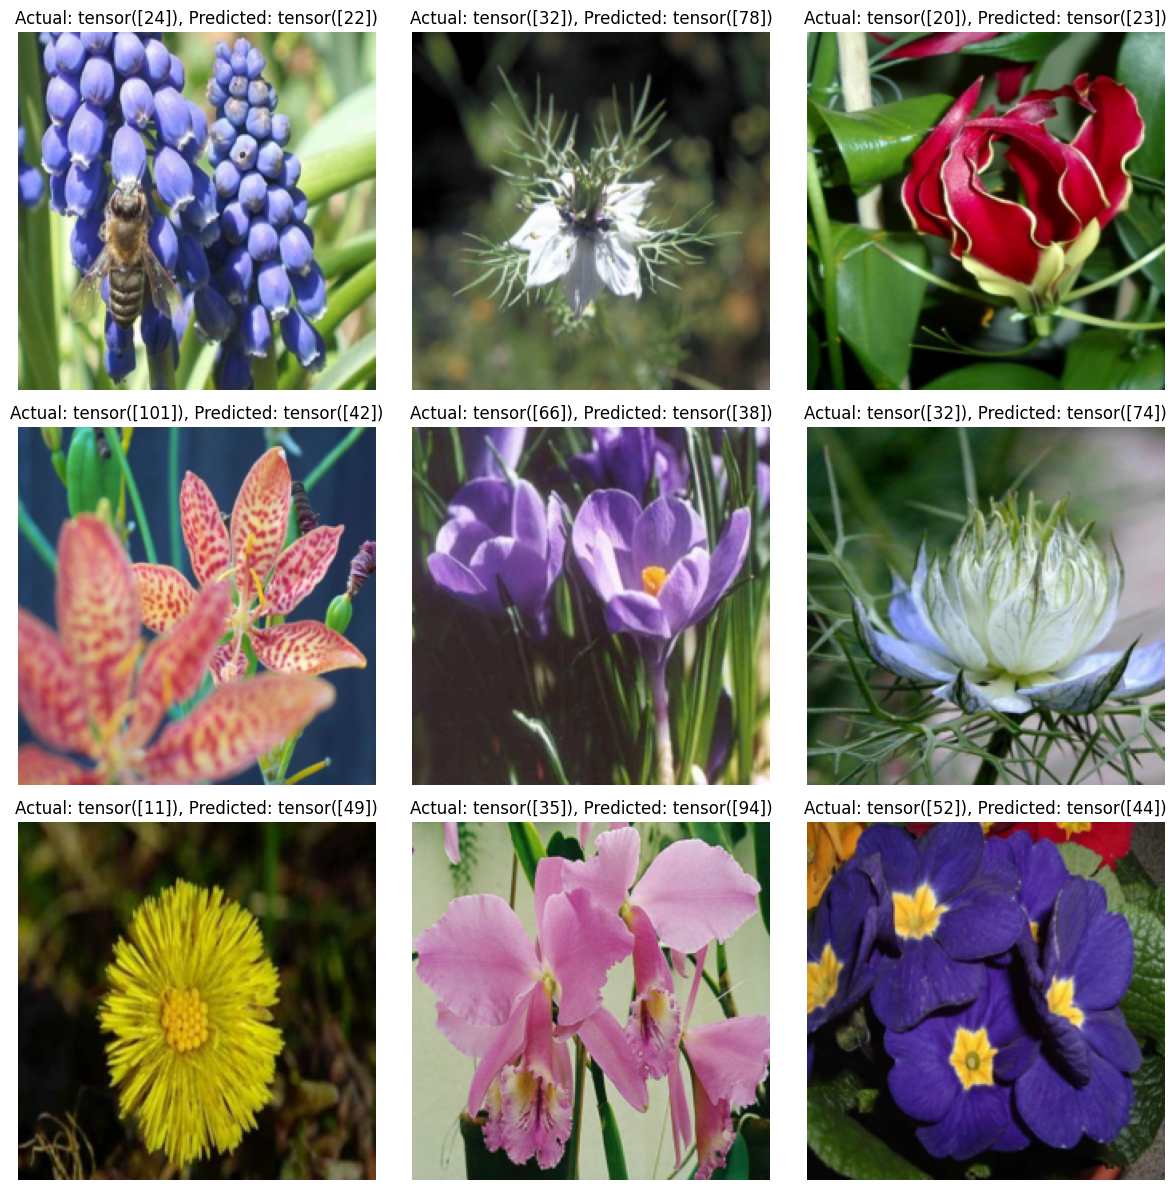

In [13]:
def evaluate(model, evaluation_loader, criterion):
    model.eval()
    evaluation_loss = 0.0
    correct = 0
    total = 0
    misclassified_images = []

    with torch.no_grad():
        for inputs, labels in evaluation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            evaluation_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            misclassified_inds = (predicted != labels).nonzero()
            for mis_ind in misclassified_inds:
                mis_img = inputs[mis_ind].cpu()
                mis_label = labels[mis_ind].cpu()
                mis_pred = predicted[mis_ind].cpu()
                misclassified_images.append((mis_img, mis_label, mis_pred))

    evaluation_loss /= len(evaluation_loader.dataset)
    evaluation_accuracy = correct / total

    print(f'Evaluation Loss: {evaluation_loss:.4f}, Accuracy: {evaluation_accuracy:.4f}')

    return misclassified_images

misclassified_images = evaluate(model, evaluation_loader, criterion)
print(f'There were {len(misclassified_images)} images predicted incorrectly by the model.')

# Plot random misclassified images
figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 3
selected_indices = random.sample(range(len(misclassified_images)), min(cols * rows, len(misclassified_images)))
for i, index in enumerate(selected_indices, 1):
    mis_img, mis_label, mis_pred = misclassified_images[index]
    np_img = (mis_img.squeeze().permute(1, 2, 0).numpy() * std.numpy() + mean.numpy()).clip(0, 1)
    figure.add_subplot(rows, cols, i)
    plt.title(f'Actual: {mis_label}, Predicted: {mis_pred}')
    plt.imshow((np_img * 255).astype('uint8'))
    plt.axis('off')

plt.tight_layout()
plt.show()

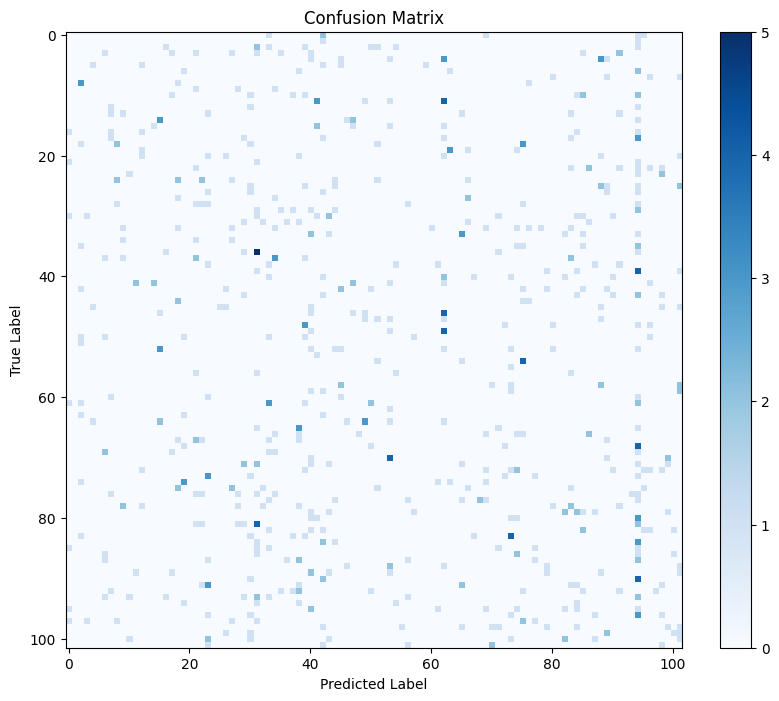

In [14]:
def create_confusion_matrix(misclassified_images):
    confusion_matrix = np.zeros((102, 102), dtype=int)

    for _, true_label, predicted_label in misclassified_images:
        confusion_matrix[true_label, predicted_label] += 1

    return confusion_matrix


def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

conf_matrix = create_confusion_matrix(misclassified_images)
plot_confusion_matrix(conf_matrix)

In [15]:
def list_misclassification_examples_per_class(misclassified_images, num_examples=1):
    classes_dict = {}
    total_misclassified = 0

    for _, true_label, pred_label in misclassified_images:
        true_label = true_label.item()  # Convert tensor to integer
        pred_label = pred_label.item()  # Convert tensor to integer
        if true_label not in classes_dict:
            classes_dict[true_label] = {"count": 0, "examples": []}
        if classes_dict[true_label]["count"] < num_examples:
            classes_dict[true_label]["examples"].append(pred_label)
        classes_dict[true_label]["count"] += 1
        total_misclassified += 1

    for true_label, misclassified_info in classes_dict.items():
        print(f"True Label: {true_label}, Misclassified Count: {misclassified_info['count']}")

    print(f"Total Misclassified Images: {total_misclassified}")

# Assuming num_classes is defined and represents the total number of classes
num_classes = 102  # Adjust this according to your dataset

# List misclassification examples per class
list_misclassification_examples_per_class(misclassified_images)

True Label: 0, Misclassified Count: 6
True Label: 1, Misclassified Count: 2
True Label: 2, Misclassified Count: 9
True Label: 3, Misclassified Count: 10
True Label: 4, Misclassified Count: 10
True Label: 5, Misclassified Count: 5
True Label: 6, Misclassified Count: 5
True Label: 7, Misclassified Count: 4
True Label: 8, Misclassified Count: 5
True Label: 9, Misclassified Count: 3
True Label: 10, Misclassified Count: 9
True Label: 11, Misclassified Count: 9
True Label: 12, Misclassified Count: 3
True Label: 13, Misclassified Count: 6
True Label: 14, Misclassified Count: 7
True Label: 15, Misclassified Count: 6
True Label: 20, Misclassified Count: 7
True Label: 16, Misclassified Count: 5
True Label: 17, Misclassified Count: 8
True Label: 18, Misclassified Count: 8
True Label: 19, Misclassified Count: 6
True Label: 21, Misclassified Count: 3
True Label: 22, Misclassified Count: 8
True Label: 23, Misclassified Count: 4
True Label: 24, Misclassified Count: 10
True Label: 25, Misclassified Co